<a href="https://colab.research.google.com/github/tavakohr/BasicFunctions/blob/master/RealEstate_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R Project to predic the sale price

In [2]:
%load_ext rpy2.ipython
from google.colab import files

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


##1.1 load spreadsheet for training 

In [3]:
Spreadsheet = files.upload()

Saving Spreadsheet-5.xlsx to Spreadsheet-5.xlsx


##1.2  load HPI index

In [4]:
HPI = files.upload()

Saving HPI.csv to HPI.csv


## 1.3 load Sale to Active index

In [5]:
SaleToActive= files.upload()

Saving SaleToActive.csv to SaleToActive.csv


In [192]:
%%R
if (!require(gridExtra)) install.packages('gridExtra')

In [193]:
%%R
if (!require(fastDummies)) install.packages('fastDummies')

In [194]:
%%R
if (!require(lme4)) install.packages('lme4')
if (!require(caret)) install.packages('caret')



## 1.4 load requirements

In [129]:
%%R
library(readxl)
library(tidyverse)
library(lme4)
library(caret)
library(lubridate)
library(rpart)
library(readxl)
library(fastDummies)
library(gridExtra)

R[write to console]: 
Attaching package: ‘gridExtra’


R[write to console]: The following object is masked from ‘package:dplyr’:

    combine




## 1.5 Create Calibration plot function

In [146]:
%%R
myrank<-function(longvector){
  longvector_orderd<-sort(longvector)
  bin=length(longvector_orderd)/10
  rank=floor((row_number(longvector_orderd)-1)/bin)
  df=cbind.data.frame(rank=rank ,longvector)
  return(df)
  
}


caliberPlot<-function(observed, prdedict){
  
  
  calib_pred<-myrank(prdedict) 
  calib_pred<-cbind.data.frame(calib_pred,observed=observed)
  
  
  gdf=calib_pred %>% group_by(rank) %>% summarise(mean_predict=mean(longvector))
  gdf2=calib_pred %>% group_by(rank) %>% summarise(mean_observed=mean(observed))
  gdf3<-cbind.data.frame(gdf,gdf2[,2])
  
  ggplot(data=gdf3,aes(x=mean_predict,y=mean_observed))+geom_line()+geom_abline(colour='blue')
}

#2 Data Cleaning

## 2.1- import and clean sale records ################################

In [56]:
%%R
a_imported<-read_excel('Spreadsheet-5.xlsx', sheet='Spreadsheet-5')
a_imported<-a_imported %>%   rename( List.Date ='List Date' )
a_imported<-a_imported %>%   rename( Tax ='Gross Taxes' ) %>% 
  rename( Tot.BR ='Tot BR' ) %>% rename( Tot.Baths ='Tot Baths' ) %>%  rename(  Kitchens  ='#Kitchens' ) %>% 
  rename(  Distance.Pub  ='Distance to Pub/Rapid Tr' ) %>% 
  rename(  Lot  ='Lot Sz (Sq.Ft.)' ) %>%   rename(  Style.of.Home  ='Style of Home' ) %>%   rename(  Yr.Blt  ='Yr Blt' ) %>% 
  rename(  ML..  ='ML #' ) %>%   rename( Approx.Yr.of.Renos.Addns='Approx.Yr of Renos/Addns' ) %>% 
  rename( S.A='S/A' ) %>% 
  rename( ML='ML..' ) %>% 
  filter(TypeDwel=='HOUSE', Tax>0)

a_imported<-a_imported %>% filter(Address!='' )
#a_imported$List.Date <- mdy(a_imported$ List.Date)
a_imported$Price=as.numeric(gsub('\\$|,', '', a_imported$Price))


In [57]:
%%R
names(a_imported)

 [1] "ML"                        "Address"                  
 [3] "City"                      "S.A"                      
 [5] "Price"                     "ListPrice"                
 [7] "OriginalPrice"             "List.Date"                
 [9] "DOM"                       "Tot.BR"                   
[11] "Tot.Baths"                 "TotFlArea"                
[13] "Yr.Blt"                    "Age"                      
[15] "Frontage - Feet"           "Depth"                    
[17] "Kitchens"                  "TypeDwel"                 
[19] "Style.of.Home"             "Price Per SQFT"           
[21] "Sold Price per SqFt"       "Lot"                      
[23] "Zoning"                    "Approx.Yr.of.Renos.Addns" 
[25] "Distance.Pub"              "Parking Places - Total"   
[27] "Title to Land"             "Tax"                      
[29] "Age Type"                  "Area"                     
[31] "Billing"                   "Board Loaded Listing"     
[33] "Broker Reciprocity

### 2.1.1 create city column with acronym

In [58]:
%%R
#str(a_imported)
table(a_imported$Distance.Pub)

a_imported_0 <- a_imported %>% mutate(SaletoAcrive_YM=paste(year(List.Date ), month(List.Date), sep='')) %>%  rename( AskingPrice='ListPrice' ) %>%
  rename( SalePrice='Price' )    

a_imported_0 <- a_imported_0 %>% mutate(HPI_YM=paste(year(List.Date ), month(List.Date), sep='')) %>% filter(Tax>0) %>% 
  mutate(city=if_else(City=='Port Coquitlam','VPQ','VCQ'))

## 2.2  clean sale and HPI indicators  


In [59]:
%%R
# for now I just have the coquitlam's records , I assume the indicators in both coquitlam and POCO changed in the same direction

SaletoAcrive<-read.csv('SaleToActive.csv' )
HPI<-read.csv('HPI.csv' )
 
SaletoAcrive$Date<-as.Date( SaletoAcrive$Date)
HPI$Date<-as.Date(HPI$Date)
#str(SaletoAcrive)
#str(HPI)
# each indicator is a predictive variable for the next month not the same one:

SaletoAcrive<-SaletoAcrive %>% mutate(SaletoAcrive_YM=paste(year(Date %m+% months(1)), month(Date %m+% months(1)), sep='') )

HPI<-HPI %>% mutate(HPI_YM=paste(year(Date %m+% months(1)), month(Date %m+% months(1)), sep=''))

#Left join main data sets to the indicator tables:
#str(a_imported)
a_imported_1<-left_join (a_imported_0,SaletoAcrive, by=c('city','SaletoAcrive_YM')) %>% dplyr::select(-Date)
a_imported_2<-left_join (a_imported_1,HPI,    by=c('city','HPI_YM'))



db<-rbind.data.frame(a_imported_2 )


db<-db %>% filter(TypeDwel=='HOUSE' )

db$Lot <- as.numeric(gsub('\\$|,', '', db$Lot))
db$TotFlArea <- as.numeric(gsub('\\$|,', '', db$TotFlArea))
db$S.A<-as.factor(db$S.A)
table(db$S.A)
#str(db)

db$month <- month(db$List.Date)
db$year <- year(db$List.Date)


db<-db %>% mutate(reno=ifelse(is.na(Approx.Yr.of.Renos.Addns),
                              0,ifelse(Approx.Yr.of.Renos.Addns>2016,3,ifelse(Approx.Yr.of.Renos.Addns<=2016 &Approx.Yr.of.Renos.Addns>2010 ,2,1)) ))
table(db$reno)


#str(db) 

db<-db %>% select(ML,SalePrice,AskingPrice,Tot.BR,Tot.Baths, Age,Kitchens,TotFlArea,Lot,S.A,month,year, reno,List.Date,SaleToActive ,HPI,Tax)
#str(db)


names(db)

 [1] "ML"           "SalePrice"    "AskingPrice"  "Tot.BR"       "Tot.Baths"   
 [6] "Age"          "Kitchens"     "TotFlArea"    "Lot"          "S.A"         
[11] "month"        "year"         "reno"         "List.Date"    "SaleToActive"
[16] "HPI"          "Tax"         


In [60]:
%%R
head(db)

# A tibble: 6 x 17
  ML       SalePrice AskingPrice Tot.BR Tot.Baths   Age Kitchens TotFlArea   Lot
  <chr>        <dbl>       <dbl>  <dbl>     <dbl> <dbl>    <dbl>     <dbl> <dbl>
1 R2568777    660000      680000      3         0    69        1      1233  4026
2 R2545292    725000      749900      2         1   107        1      1759  4197
3 R2541391    780300      738000      4         3    46        2      1535  3000
4 R2563286    800000      809900      3         2    46        1      1343  3000
5 R2541325    800000      750000      3         2    45        1      1254  3000
6 R2533252    810000      799988      2         1    65        1       751  4039
# … with 8 more variables: S.A <fct>, month <dbl>, year <dbl>, reno <dbl>,
#   List.Date <dttm>, SaleToActive <dbl>, HPI <int>, Tax <dbl>


## 2.3 apply the cooks distance to remove high leverage points  


In [61]:
%%R
db_fit<-glm(SalePrice~AskingPrice  ,
                  family = gaussian(link = "identity"),
                  data=db)
High_leverage<-db[cooks.distance(db_fit)>1,]
High_leverage



# A tibble: 1 x 17
  ML       SalePrice AskingPrice Tot.BR Tot.Baths   Age Kitchens TotFlArea   Lot
  <chr>        <dbl>       <dbl>  <dbl>     <dbl> <dbl>    <dbl>     <dbl> <dbl>
1 R2527268   3700000     4700000      2         1    74        1      2100 46217
# … with 8 more variables: S.A <fct>, month <dbl>, year <dbl>, reno <dbl>,
#   List.Date <dttm>, SaleToActive <dbl>, HPI <int>, Tax <dbl>


###2.3.1 Exclude cases with huge abnormality in asking and sale price

In [62]:
%%R
db<-db[cooks.distance(db_fit)<=1,]


In [48]:
%%R
dim(db)

[1] 956  17


## 2.4 exclude the outlires

### 2.4.1 Price per bedroom

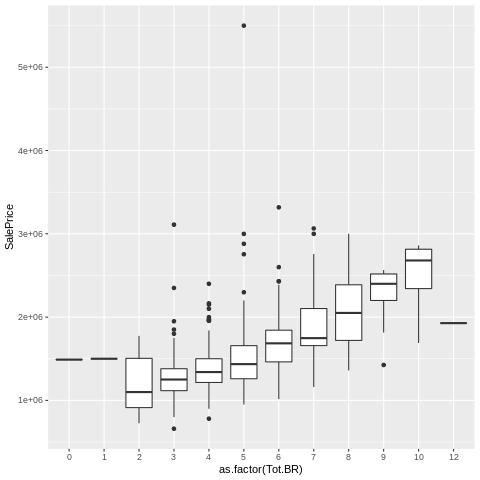

In [63]:
%%R
ggplot(data=db,aes(x=as.factor(Tot.BR),y=SalePrice))+geom_boxplot()

In [89]:
%%R
db<-db[db$Tot.BR<11,]
db<-db[db$Tot.BR>1,]

### 2.4.2 Price per lot per building age

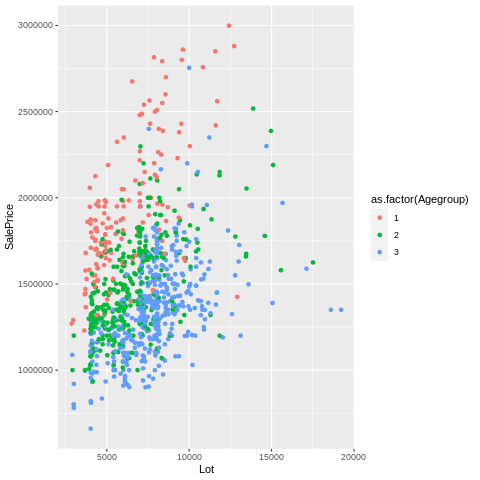

In [90]:
%%R
db<-db %>% mutate(Agegroup=ifelse(Age <15 ,1,ifelse(Age<40,2,3)))
table(db$Agegroup)
ggplot(data=db,aes(x=Lot,y=SalePrice))+geom_point(aes(colour=as.factor(Agegroup)))

In [91]:
%%R
db<-db[db$Lot<20000,]
db<-db[db$Lot>1000,]


In [93]:
%%R
db<-db[db$SalePrice<3000000,]

### 2.4.3 After cleaning SalePrice and Lot size

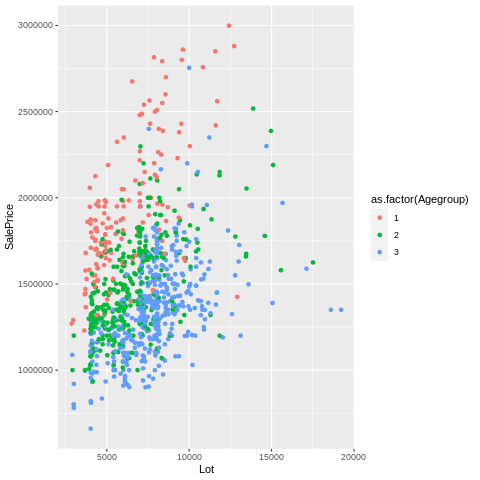

In [94]:
%%R
ggplot(data=db,aes(x=Lot,y=SalePrice))+geom_point(aes(colour=as.factor(Agegroup)))

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



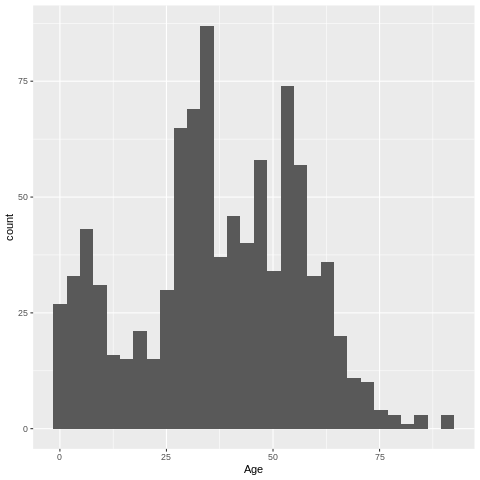

In [95]:
%%R
ggplot(data=db,aes(x=Age))+geom_histogram()

In [96]:
%%R
db<-db[db$Age<100,]

## 3.1 Create training and Testing Sets


In [97]:
%%R
training<-db %>% filter(List.Date<='2021-04-30')   
testing<-db %>% filter( List.Date>'2021-04-30' )

In [98]:
%%R

training <- training %>% dplyr::select(ML,AskingPrice ,SalePrice,Tot.BR,Tot.Baths, Age,Kitchens,TotFlArea,Lot,S.A,Tax , reno,List.Date,SaleToActive ,HPI)
testing <-  testing  %>% dplyr::select(ML,AskingPrice ,SalePrice,Tot.BR,Tot.Baths, Age,Kitchens,TotFlArea,Lot,S.A,Tax , reno,List.Date,SaleToActive ,HPI)


In [114]:
%%R
table(training$S.A)


VCQBM VCQCC VCQCE VCQCH VCQCS VCQCW VCQCY VCQER VCQHC VCQHO VCQHP VCQMB VCQML 
   68    93    42    14    13    58    10     6     9     9    17    11    32 
VCQNH VCQRP VCQRS VCQSC VCQSV VCQUE VCQWP VCQWS VPQBL VPQCE VPQCI VPQGL VPQLM 
   21    46     1    14     2     8    74     2    12    20    35    46    19 
VPQLP VPQMH VPQOH VPQRD VPQWA 
   37    34    22    27    15 


In [115]:
%%R
table(testing$S.A)


VCQBM VCQCC VCQCE VCQCH VCQCS VCQCW VCQCY VCQER VCQHC VCQHO VCQHP VCQMB VCQML 
    8    17     6     4     1     5     1     0     1     2     3     2     1 
VCQNH VCQRP VCQRS VCQSC VCQSV VCQUE VCQWP VCQWS VPQBL VPQCE VPQCI VPQGL VPQLM 
    5     8     0     1     1     1     7     1     1     1     0     7     1 
VPQLP VPQMH VPQOH VPQRD VPQWA 
    3     3     9     2     3 


In [119]:
%%R
testing<- testing[testing['S.A']!='VCQRS' &testing['S.A']!='VCQSV' , ]

### 3.1.1 Scaling training and testing sets

In [120]:
%%R
set.seed(96)
preProcValues <- preProcess(training[c('Age','TotFlArea' ,'Lot' , 'SaleToActive','Tax')], method = c("center", "scale"))
 
trainTransformed <- predict(preProcValues, training)
testTransformed <- predict(preProcValues, testing)

# 4  Statistical models

# 4.1 GLM normal distribution ( simple model without geographical variable)

In [121]:
%%R

simple_Normal<-glm(SalePrice~ AskingPrice+Tot.BR+Tot.Baths+ Age+Kitchens+TotFlArea+ Lot+ reno +Tax+HPI+SaleToActive,
                  family =  gaussian(link = "identity"),
                  data=training)
summary(simple_Normal)


Call:
glm(formula = SalePrice ~ AskingPrice + Tot.BR + Tot.Baths + 
    Age + Kitchens + TotFlArea + Lot + reno + Tax + HPI + SaleToActive, 
    family = gaussian(link = "identity"), data = training)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1215990    -64992    -11827     59599    446562  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.542e+03  5.173e+04  -0.049 0.960823    
AskingPrice   7.950e-01  1.953e-02  40.695  < 2e-16 ***
Tot.BR       -4.645e+03  4.226e+03  -1.099 0.271999    
Tot.Baths     4.236e+03  5.363e+03   0.790 0.429881    
Age          -1.099e+02  3.074e+02  -0.357 0.720902    
Kitchens      5.344e+03  6.808e+03   0.785 0.432698    
TotFlArea     1.474e+01  7.450e+00   1.979 0.048184 *  
Lot           2.623e+00  1.993e+00   1.316 0.188519    
reno          8.798e+03  3.255e+03   2.703 0.007019 ** 
Tax           2.248e+01  5.481e+00   4.101 4.53e-05 ***
HPI           1.111e-01  3.255e-02   3.412 0

### 4.1.1 Simple Regression ,Bedroom exploration

In [122]:
%%R
Bedroom_simple<-glm(SalePrice~ Tot.BR,
                  family =  gaussian(link = "identity"),
                  data=training)
summary(Bedroom_simple)


Call:
glm(formula = SalePrice ~ Tot.BR, family = gaussian(link = "identity"), 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-703559  -197751   -30737   154087  1467087  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   786106      35190   22.34   <2e-16 ***
Tot.BR        149162       7033   21.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 84336813605)

    Null deviance: 1.0667e+14  on 816  degrees of freedom
Residual deviance: 6.8735e+13  on 815  degrees of freedom
AIC: 22877

Number of Fisher Scoring iterations: 2



### 4.1.2 Simple regression shows there is association between bedroom and sale price while the multiple regression there is negative association, It means that owners overestimated the bedroom effect on thier price calculation given other variables

In [123]:
%%R
Bedroom_simple_Asking<-glm(SalePrice~ AskingPrice+Tot.BR+Tot.Baths,
                  family =  gaussian(link = "identity"),
                  data=training)
summary(Bedroom_simple_Asking)


Call:
glm(formula = SalePrice ~ AskingPrice + Tot.BR + Tot.Baths, family = gaussian(link = "identity"), 
    data = training)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1197981    -65802    -14318     64429    424946  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.017e+05  1.565e+04  12.889   <2e-16 ***
AskingPrice  8.744e-01  1.389e-02  62.942   <2e-16 ***
Tot.BR      -7.625e+01  3.723e+03  -0.020   0.9837    
Tot.Baths    8.852e+03  4.247e+03   2.084   0.0375 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 10731548128)

    Null deviance: 1.0667e+14  on 816  degrees of freedom
Residual deviance: 8.7247e+12  on 813  degrees of freedom
AIC: 21194

Number of Fisher Scoring iterations: 2



### 4.1.3 Simple regression ,R squared for 

In [124]:
%%R
with(summary(simple_Normal), 1 - deviance/null.deviance)

[1] 0.9233525


### 4.1.4 Simple Regression,Prediction for SalePrice

In [148]:
%%R
P_simple_normal<-as.vector(predict(simple_Normal, newdata =testing, type="response"))

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



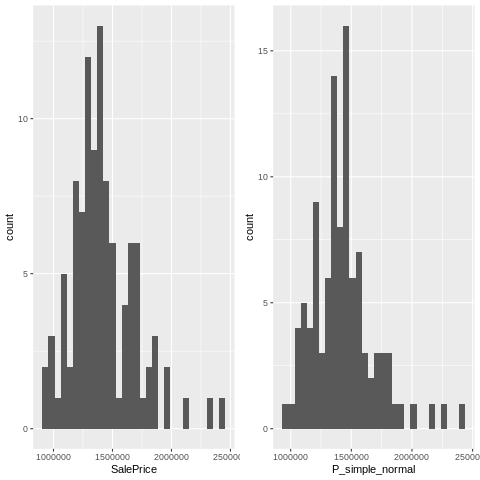

In [142]:
%%R
plot1<-ggplot(data=testing,aes(x=SalePrice))+geom_histogram()
plot2<-ggplot(data=data.frame(P_simple_normal=P_simple_normal),aes(x=P_simple_normal))+geom_histogram()
grid.arrange(plot1, plot2, ncol=2)

### 4.1.5 Simple Regression,Calibration plot

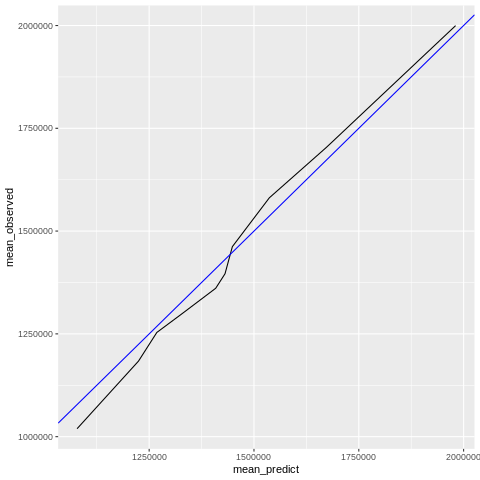

In [147]:
%%R
caliberPlot(testing$SalePrice, P_simple_normal) 

# 4.2 GLM Gamma distribution

In [158]:
%%R

simple_Gamma<-glm(SalePrice~ AskingPrice+Tot.BR+Tot.Baths+ Age+Kitchens+TotFlArea+ Lot+ reno +Tax+HPI+SaleToActive+Lot*Age+Tot.BR*Tot.Baths,
                  family =  Gamma(link = "log"),
                  data=training)
summary(simple_Gamma)


Call:
glm(formula = SalePrice ~ AskingPrice + Tot.BR + Tot.Baths + 
    Age + Kitchens + TotFlArea + Lot + reno + Tax + HPI + SaleToActive + 
    Lot * Age + Tot.BR * Tot.Baths, family = Gamma(link = "log"), 
    data = training)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.52755  -0.04363  -0.00645   0.04177   0.22584  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.317e+01  4.325e-02 304.497  < 2e-16 ***
AskingPrice       4.759e-07  1.368e-08  34.776  < 2e-16 ***
Tot.BR            2.644e-02  4.617e-03   5.727 1.44e-08 ***
Tot.Baths         4.867e-02  7.084e-03   6.869 1.29e-11 ***
Age              -2.948e-03  4.466e-04  -6.600 7.45e-11 ***
Kitchens         -1.116e-03  4.729e-03  -0.236 0.813525    
TotFlArea         1.107e-05  5.303e-06   2.087 0.037159 *  
Lot              -1.240e-05  2.650e-06  -4.681 3.35e-06 ***
reno              6.746e-03  2.292e-03   2.943 0.003343 ** 
Tax               1.948e-05  3

## 4.2.1 Simple Gamma ,R Sqared

In [154]:
%%R
with(summary(simple_Gamma), 1 - deviance/null.deviance)

[1] 0.9092244


4.2.2 Simple Gamma,Prediction for SalePrice

In [155]:
%%R
P_simple_Gamma<-as.vector(predict(simple_Gamma, newdata =testing, type="response"))

4.2.3 Simple Gamma  ,Calibration plot

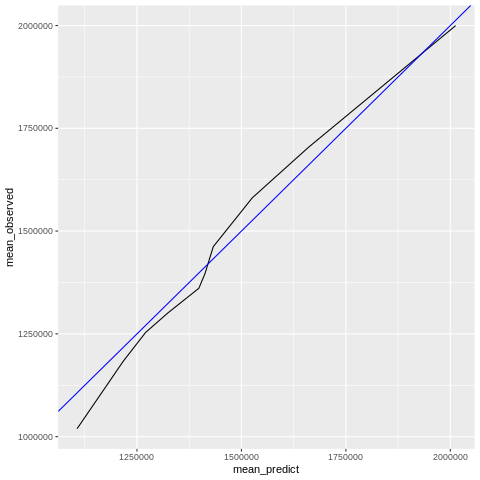

In [156]:
%%R
caliberPlot(testing$SalePrice, P_simple_Gamma) 

# 4.3 GLM Normal distribution - with Zone (Complex method)

In [165]:
%%R

complex_normal<-glm(SalePrice~ AskingPrice+Tot.BR+Tot.Baths+ Age+Kitchens+TotFlArea+ Lot+ reno +Tax+HPI+SaleToActive+Lot*Age+Tot.BR*Tot.Baths+S.A,
                  family =  gaussian(link = "identity"),
                  data=training)
#summary(complex_normal)

### 4.3.1 complex normal ,R Sqared

In [167]:
%%R
with(summary(complex_normal), 1 - deviance/null.deviance)

[1] 0.9289667


### 4.3.2 complex normal,Prediction for SalePrice

In [168]:
%%R
P_complex_normal<-as.vector(predict(complex_normal, newdata =testing, type="response"))

### 4.3.3 complex normal ,Calibration plot

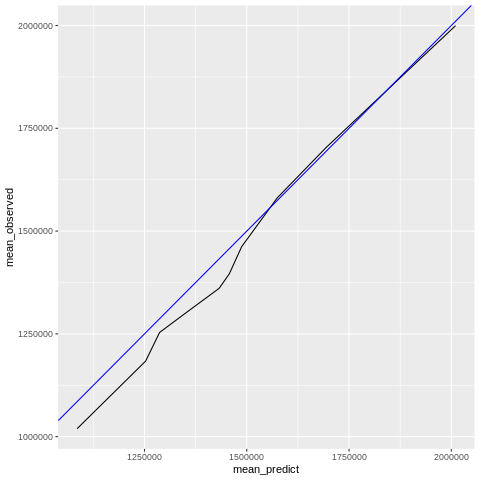

In [169]:
%%R
caliberPlot(testing$SalePrice, P_complex_normal) 

# 4.4 Mixed model

In [188]:
%%R
fit.lmer <- lmer(SalePrice~ AskingPrice+ Tot.BR+Tot.Baths+ Age+Kitchens+TotFlArea+ Lot+ reno +(1| S.A)+ SaleToActive+Tax+Age*Tax+HPI+TotFlArea*Age,
                 data=training)

### 4.4.1  mixed model,Prediction for SalePrice

In [189]:
%%R
 
P_mixed<-as.vector(predict(fit.lmer, newdata =testing, type="response"))

### 4.4.2 Mixed ,Calibration plot

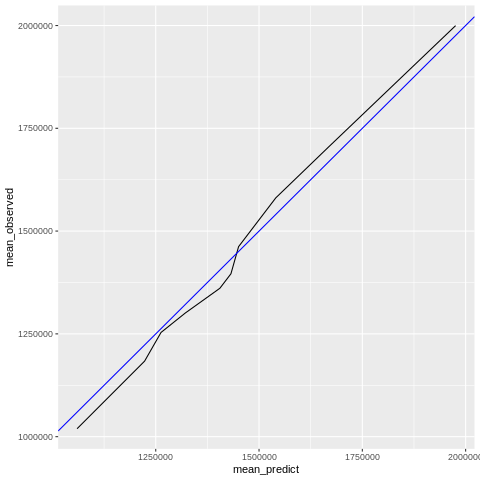

In [190]:
%%R
caliberPlot(testing$SalePrice, P_mixed)

## 4.4.3 Mixed ,R squared

In [191]:
%%R
tmp<-cbind.data.frame(training, pred=as.vector(predict(fit.lmer, newdata =training, type="response")))
yhat<-mean(tmp$SalePrice)
tmp<-tmp %>% mutate(res2=(pred-SalePrice)^2) %>% mutate(tss2=(yhat-SalePrice)^2)
#head(tmp)

1-(sum(tmp$res2)/sum(tmp$tss2))

[1] 0.9270478


# 5. Output results

In [210]:
%%R
test_output<-cbind.data.frame(ML=testing$ML, P_simple_normal=P_simple_normal ,P_simple_Gamma =P_simple_Gamma,P_complex_normal=P_complex_normal,P_mixed=P_mixed,
                              AskingPrice=testing$AskingPrice, SalePrice=testing$SalePrice)

write.csv(test_output,'test_output.csv')

In [211]:
import pandas as pd
df=pd.read_csv('test_output.csv')

df.round()

,Unnamed: 0,ML,P_simple_normal,P_simple_Gamma,P_complex_normal,P_mixed,AskingPrice,SalePrice
0,1,R2578053,983977.0,1009918.0,932870.0,943866.0,865000.0,920000
1,2,R2574782,1087540.0,1039784.0,1028613.0,1035292.0,999999.0,933000
2,3,R2583335,1060931.0,1113009.0,1103771.0,1055638.0,949889.0,962500
3,4,R2588413,1064912.0,1077523.0,1092846.0,1031308.0,988800.0,975000
4,5,R2576895,977498.0,1042248.0,1008318.0,971709.0,859900.0,979000
...,...,...,...,...,...,...,...,...
99,100,R2583500,2013630.0,2004242.0,2035202.0,1998167.0,2000000.0,1955000
100,101,R2578852,1796044.0,1802247.0,1837722.0,1811617.0,1850000.0,1985050
101,102,R2574827,2161322.0,2190088.0,2188214.0,2158794.0,2188000.0,2100000
102,103,R2582402,2269818.0,2367734.0,2292584.0,2236361.0,2288000.0,2325000
